In [1]:
import numpy as np
import pandas as pd

## importing functions 

In [2]:
def get_ind_file(filetype, weighting="vw", n_inds=30):
    """
    Load and format the Ken French Industry Portfolios files
    Variant is a tuple of (weighting, size) where:
        weighting is one of "ew", "vw"
        number of inds is 30 or 49
    """    
    if filetype == "returns":
        name = f"{weighting}_rets" 
        divisor = 100
    elif filetype == "nfirms":
        name = "nfirms"
        divisor = 1
    elif filetype == "size":
        name = "size"
        divisor = 1
    else:
        raise ValueError(f"filetype must be one of: returns, nfirms, size")
    
    ind = pd.read_csv(f"data/ind{n_inds}_m_{name}.csv", header=0, index_col=0, na_values=-99.99)/divisor
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind


def get_ind_returns(weighting="vw", n_inds=30):
    """
    Load and format the Ken French Industry Portfolios Monthly Returns
    """
    return get_ind_file("returns", weighting=weighting, n_inds=n_inds)

def get_ind_nfirms(n_inds=30):
    """
    Load and format the Ken French 30 Industry Portfolios Average number of Firms
    """
    return get_ind_file("nfirms", n_inds=n_inds)

def get_ind_size(n_inds=30):
    """
    Load and format the Ken French 30 Industry Portfolios Average size (market cap)
    """
    return get_ind_file("size", n_inds=n_inds)


def get_ind_market_caps(n_inds=30, weights=False):
    """
    Load the industry portfolio data and derive the market caps
    """
    ind_nfirms = get_ind_nfirms(n_inds=n_inds)
    ind_size = get_ind_size(n_inds=n_inds)
    ind_mktcap = ind_nfirms * ind_size
    if weights:
        total_mktcap = ind_mktcap.sum(axis=1)
        ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
        return ind_capweight
    #else
    return ind_mktcap

def get_total_market_index_returns(n_inds=30):
    """
    Load the 30 industry portfolio data and derive the returns of a capweighted total market index
    """
    ind_capweight = get_ind_market_caps(n_inds=n_inds)
    ind_return = get_ind_returns(weighting="vw", n_inds=n_inds)
    total_market_return = (ind_capweight * ind_return).sum(axis="columns")
    return total_market_return

## helper functions 

In [3]:
def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    w = cap_weights.loc[r.index[0]]
    return w/w.sum()

def weight_ew(r, cap_weights=None, max_cw_mult=None, microcap_threshold=None, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    If supplied a set of capweights and a capweight tether, it is applied and reweighted 
    """
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    if cap_weights is not None:
        cw = cap_weights.loc[r.index[0]] # starting cap weight
        ## exclude microcaps
        if microcap_threshold is not None and microcap_threshold > 0:
            microcap = cw < microcap_threshold
            ew[microcap] = 0
            ew = ew/ew.sum()
        #limit weight to a multiple of capweight
        if max_cw_mult is not None and max_cw_mult > 0:
            ew = np.minimum(ew, cw*max_cw_mult)
            ew = ew/ew.sum() #reweight
    return ew

def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    w = cap_weights.loc[r.index[0]]
    return w/w.sum()


def backtest_ws(r, estimation_window=60, weighting=weight_ew, verbose=False, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    # return windows
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window)]
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # convert List of weights to DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window:].index, columns=r.columns)
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

## summary functions

In [4]:
import scipy.stats
from scipy.stats import norm
def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4

def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})



def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())

                         
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol



def is_normal(r, level=0.01):
    """
    Applies the Jarque-Bera test to determine if a Series is normal or not
    Test is applied at the 1% level by default
    Returns True if the hypothesis of normality is accepted, False otherwise
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(is_normal)
    else:
        statistic, p_value = scipy.stats.jarque_bera(r)
        return p_value > level


def semideviation(r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame, else raises a TypeError
    """
    if isinstance(r, pd.Series):
        is_negative = r < 0
        return r[is_negative].std(ddof=0)
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(semideviation)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")



def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))
    
def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

## GmV functions 

In [5]:
def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)

def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    return r.cov()

def weight_gmv(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the GMV portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return gmv(est_cov)

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    vol = (weights.T @ covmat @ weights)**0.5
    return vol 

### Importing Data

In [14]:
#inds=['Beer', 'Hlth', 'Fin','Rtail','Whlsl']
ind_rets = get_ind_returns(weighting="vw", n_inds=49)["2014":]
ind_mcap = get_ind_market_caps(49, weights=True)["2014":]

rets = ind_rets["2014":]
cov = rets.cov()

# 1- Risk Contribution for each 

In [16]:
def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

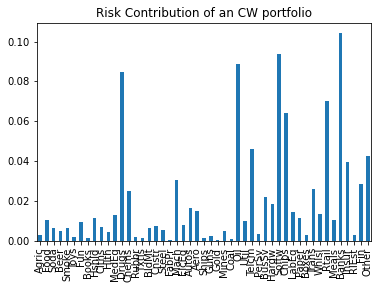

In [39]:
risk_contribution(weight_cw(rets,ind_mcap), cov).plot.bar(title='Risk Contribution of an CW portfolio')

In [31]:
risk_contribution_cw = risk_contribution(weight_cw(rets,ind_mcap), cov)

##### 1- Enter your answer as text, exactly as they are named in the Data file (i.e. 'Hlth', 'Fin', 'Whlsl', 'Rtail', or 'Food')

##### 2- Use the same data as the previous question. What was the highest risk contribution from any one industry in the cap-weighted portfolio?

Enter the answer as a percentage (e.g. for 5.67% enter 5.67)

In [32]:
risk_contribution_cw[risk_contribution_cw == risk_contribution_cw.max()]

Banks    0.10406
dtype: float64

In [36]:
risk_contribution_ew = risk_contribution(weight_ew(rets), cov)

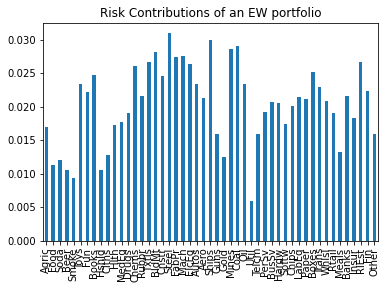

In [37]:
risk_contribution_ew.plot.bar(title="Risk Contributions of an EW portfolio");

#### 3- Which Industry had the highest risk contribution in the equal-weighted portfolio?

Enter your answer as text, exactly as they are named in the Data file (i.e. 'Hlth', 'Fin', 'Whlsl', 'Rtail', or 'Food')

#### 4- What was the highest risk contribution from any one industry in the equal-weighted portfolio?

Enter the answer as a percentage (e.g. for 5.67% enter 5.67)

In [41]:
risk_contribution_ew[risk_contribution_ew == risk_contribution_ew.max()]

Steel    0.030938
dtype: float64

#### functions to equaly weight the risk inside the portifolio

In [43]:
from scipy.optimize import minimize

def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)


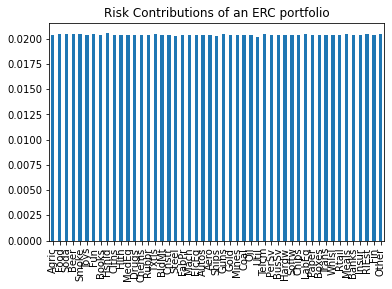

In [45]:
#weights that gives equal risk contributions
risk_contribution(equal_risk_contributions(cov), cov).plot.bar(title="Risk Contributions of an ERC portfolio");

In [54]:
def weight_erc(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the ERC portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return equal_risk_contributions(est_cov)

In [56]:
weight_erc(rets)

array([0.02247852, 0.03025094, 0.02823332, 0.03202826, 0.03260638,
       0.01627068, 0.01766336, 0.01542512, 0.03318412, 0.02912923,
       0.02224645, 0.02090693, 0.01973038, 0.01491777, 0.01774663,
       0.01443959, 0.0137905 , 0.01592362, 0.01280911, 0.01518338,
       0.01429176, 0.01474679, 0.01672597, 0.01798352, 0.01304069,
       0.02380923, 0.02728219, 0.01395074, 0.01475935, 0.01676373,
       0.05215573, 0.02313301, 0.01992407, 0.0184558 , 0.01865389,
       0.02196338, 0.01887783, 0.01775139, 0.01776126, 0.01524685,
       0.01676276, 0.01842073, 0.01956692, 0.02790719, 0.01844531,
       0.02097034, 0.01442949, 0.01783279, 0.02342304])

In [59]:
rets.columns

Index(['Agric', 'Food', 'Soda', 'Beer', 'Smoke', 'Toys', 'Fun', 'Books',
       'Hshld', 'Clths', 'Hlth', 'MedEq', 'Drugs', 'Chems', 'Rubbr', 'Txtls',
       'BldMt', 'Cnstr', 'Steel', 'FabPr', 'Mach', 'ElcEq', 'Autos', 'Aero',
       'Ships', 'Guns', 'Gold', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm',
       'PerSv', 'BusSv', 'Hardw', 'Softw', 'Chips', 'LabEq', 'Paper', 'Boxes',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Banks', 'Insur', 'RlEst', 'Fin',
       'Other'],
      dtype='object')

In [61]:
erc_w = pd.DataFrame({'weights':weight_erc(rets), 'Columns' : rets.columns})

In [69]:
erc_w.sort_values('weights')

,weights,Columns
18,0.012809,Steel
24,0.013041,Ships
16,0.013790,BldMt
27,0.013951,Mines
20,0.014292,Mach
46,0.014429,RlEst
15,0.014440,Txtls
21,0.014747,ElcEq
28,0.014759,Coal
13,0.014918,Chems


#### 5- Using the Sample Covariance over the 5 year period, and the initial capweights over that period, compute the weights of the ERC portfolio. What sector portfolio is assigned the highest weight in the ERC portfolio?

Enter your answer as text, exactly as they are named in the Data file (i.e. 'Hlth', 'Fin', 'Whlsl', 'Rtail', or 'Food')

#### 6- Using the same data as the previous question (Sample Covariance over the 5 year period, and the initial capweights over that period) compute the weights of the ERC portfolio. What is the weight of the sector portfolio that is assigned the highest weight in the ERC portfolio?

Enter the answer as a percentage (e.g. for 5.67% enter 5.67)

In [72]:
erc_w[erc_w['weights'] == erc_w['weights'].max()]

,weights,Columns
30,0.052156,Util


#### 7 - Use the same data as the previous question (Sample Covariance over the 5 year period, and the initial capweights over that period) and the weights of ERC portfolio. What sector portfolio is assigned the lowest weight in the ERC portfolio?

Enter your answer as text, exactly as they are named in the Data file (i.e. 'Hlth', 'Fin', 'Whlsl', 'Rtail', or 'Food')

#### 8- Use the same data as the previous question (Sample Covariance over the 5 year period, and the initial capweights over that period) and the weights of ERC portfolio.
#### What is the weight of the sector portfolio that is assigned the lowest weight in the ERC portfolio?

Enter the answer as a percentage (e.g. for 5.67% enter 5.67)

In [74]:
erc_w[erc_w['weights'] == erc_w['weights'].min()]

,weights,Columns
18,0.012809,Steel


#### 9- Use the same data as you used in the previous question (Sample Covariance over the 5 year period and the initial capweights over that period).
 #### In the cap-weighted portfolio what is the difference in risk contributions between the largest contributor to portfolio risk and the smallest contributor to portfolio risk?

Enter the answer as a percentage (e.g. for 5.67% enter 5.67)

In [85]:
max_risk_cw =risk_contribution_cw[risk_contribution_cw == risk_contribution_cw.max()][0]
min_risk_cw =risk_contribution_cw[risk_contribution_cw == risk_contribution_cw.min()][0]

max_risk_cw-min_risk_cw

0.1039644943981684

In [86]:
risk_contribution_cw[risk_contribution_cw == risk_contribution_cw.min()]

Gold    0.000096
dtype: float64

#### 10 -Use the same data as you used in the previous question (Sample Covariance over the 5 year period and the initial capweights over that period).
#### In the equal-weighted portfolio what is the difference in risk contributions between the largest contributor to portfolio risk and the smallest contributor to portfolio risk?

Enter the answer as a percentage (e.g. for 5.67% enter 5.67)

In [89]:
max_risk_ew =risk_contribution_ew[risk_contribution_ew == risk_contribution_ew.max()][0]
min_risk_ew =risk_contribution_ew[risk_contribution_ew == risk_contribution_ew.min()][0]
max_risk_ew-min_risk_ew

0.02502175762491148